### Trabalho de Redes Neurais com TensorFlow [22E3_2]

Professor: DSc. Diego Rodrigues

Aluno: Higor Souza Eller

##### Introdução

Trata-se do treinamento de uma rede neural que vai fornecer uma previsão de tempo resposta para um dado recurso em certas circunstâncias. A rede neural ajudaria na obtenção de uma estimativa de tempo para auxilar no empenho de alguma viatura para efetuar um atendimento de alguma natureza. O ciclo de desenvolvimento da solução seguiu a rotina CRISP.

##### Data understanding

Apesar do foco desta rede ser o tempo resposta de um atendimento, melhor seria se fosse o recurso. Prever qual recurso é o mais recomendado para dada ocorrência é mais útil, entretanto se trataria de um problema multiclasse com um número muito grande de classes. Por isso, os dados de tempo resposta foram categorizados em 6 categorias distintas, que são as classes de interesse do algoritmo em questão.

A base de dados inicial é composta por 822.000 ocorrências atendidas de 2018 até a data atual em 2022. Após os devidos tratamentos o número caiu para algo em torno de 430.000. As entradas são:

Entradas => ['rai',	'data',	'naturezas',	'bairro_cidade',	'recurso',	'tr',	'obm_escala',	'obm_afeto',	'qualificacao',	'sexo']

  - O número rai da ocorrência ("rai"), é uma espécie de ID da ocorrência gerado pelo sistema K9 da SSP.
  - A data ("data") do atendimento, consistindo em um registro de data e hora do acionamento.
  - A natureza do atendimento ("naturezas"). Por exemplo: ataque cardíaco, incêndio em galpão, tentativa de auto-extermínio etc.
  - A cidade e o bairro do atendimento ("bairro_cidade").
  - O tempo resposta ("tr"), o qual consiste no tempo entre o acionamento e o efetivo atendimento.
  - A Unidade Bombeiro Militar que realiza o atendimento ("obm_escala").
  - A Unidade Bombeiro Militar a qual a OBM está afeta, ou seja, a qual OBM ela responde ("obm_afeto")
  - A qualificação da vítima ("qualificacao"). Se é uma vítima comunicante, apenas um comunicante etc.
  - O sexo da vítima ("sexo"). Se é masculino, feminino ou não-informado.


Tipos de dados das entradas = {'rai' : 'int', 'data': 'timestamp', 'naturezas' : 'str', 'bairro_cidade' : 'str', 'recurso' : 'str', 'tr': 'datetime.time', 'obm_escala': 'str', 'obm_afeto': 'str', 'qualificacao': 'str', 'sexo': 'str'}

Saída => ["tempo_resposta"] => ["Muito rápido", "Rápido", "Médio", "Longo", "Muito longo", "Extremamente longo"]

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import BatchNormalization, Activation, Dropout
from joblib import dump, load
from matplotlib import pyplot
import tensorflow
import pandas
import numpy
import datetime
import seaborn
import itertools
import plotly.express as px

2022-10-01 10:57:30.993256: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### Data preparation

1. Primeiramente os dados foram carregados em um dataframe.

2. As colunas "rai", "obm_afeto", "qualificacao" foram removidas pelo fato de não serem relevantes.

3. Os valores nulos foram removidos.

4. A data que originalmente era do tipo timestamp foi separada em duas colunas categóricas, "dia" e "periodo".

5. O tempo resposta foi categorizado para gerar as classes de saída ("Muito rápido", "Rápido", "Médio", "Longo", "Muito longo", "Extremamente longo").

In [2]:
# DATA PREPARATION
file_path = '../../../dataset/occurrences.xlsx'

df = pandas.read_excel(file_path)
df = df.drop(["rai", "obm_afeto", "qualificacao"], axis=1)

#REMOVING NULL VALUES
for column in df.columns:
    df.loc[pandas.isnull(df[column])]
    df = df.loc[df[column] != "(null)"]

#TRANSFORMING "data" COLUMN INTO NEW COLUMNS "dia" e "periodo". ALSO TRANSFORMING "tr" COLUMN INTO "tempo_resposta" COLUMN

def day_name(timestamp):
    weekdays = ('Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo')
    return weekdays[timestamp.weekday()]

def period_of_day(timestamp):
    period = ("Madrugada", "Matutino", "Vespertino", "Noturno")
    # Madrugada 00:00 às 05:59
    # Matutino 06:00 às 11:59
    # Vespertino 12:00 às 17:59
    # Noturno 18:00 às 23:59
    if 0 <= timestamp.hour < 6:
        return period[0]
    elif 6 <= timestamp.hour < 12:
        return period[1]
    elif 12 <= timestamp.hour < 18:
        return period[2]
    elif 18 <= timestamp.hour < 24:
        return period[3]


def response_time(response_time):
    # Muito rápido 0 a 10 minutos
    # Rápido 10 a 15 minutos
    # Médio 15 a 20 minutos
    # Longo 20 a 30 minutos
    # Muito longo 30 a 45 minutos
    # Extremamente longo > 45 minutos

    response_time_metric = ("Muito rápido", "Rápido", "Médio", "Longo", "Muito longo", "Extremamente longo")

    if type(response_time) is datetime.time:

        total_time_in_minutes = response_time.hour*60 + response_time.minute + response_time.second/60

        if 0 <= total_time_in_minutes <= 10:
            return response_time_metric[0]
        elif 10 < total_time_in_minutes <= 15:
            return response_time_metric[1]
        elif 15 < total_time_in_minutes <= 20:
            return response_time_metric[2]
        elif 20 <  total_time_in_minutes <= 30:
            return response_time_metric[3]
        elif 30 < total_time_in_minutes <= 45:
            return response_time_metric[4]
        elif 45 < total_time_in_minutes <= 80:
            return response_time_metric[5]
        elif total_time_in_minutes > 80:
            return "Drop"
        
        
#APPLYING
df.loc[:, "dia"] = df["data"].apply(day_name)
df.loc[:, "periodo"] = df["data"].apply(period_of_day)
df.loc[:, "tempo_resposta"] = df["tr"].apply(response_time)

#REMOVING ROWS WITH MORE THAN 80 MINUTES RESPONSE TIME
df = df.loc[df["tempo_resposta"] != "Drop"]

#REMOVING "DATA" AND "TR" COLUMNS
df = df.drop(["data", "tr"], axis=1)[0:100000]

#REMOVING NONE VALUES
df = df.dropna()
df = df.mask(df.eq('None')).dropna()
df = df.astype(str)
df.head()

/home/higoreller/miniconda3/envs/condaenv/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Cell F221384 is marked as a date but the serial value -736954.9663425926 is outside the limits for dates. The cell will be treated as an error.
  for idx, row in parser.parse():


,naturezas,bairro_cidade,recurso,obm_escala,sexo,dia,periodo,tempo_resposta
5,RESGATE (3)->EMERGÊNCIA CLÍNICA (304)->ACIDENT...,ZONA RURAL - CATALÃO,UR-181,10º BBM - CATALÃO,MASCULINO,Domingo,Madrugada,Muito rápido
6,RESGATE (3)->ACIDENTE DE TRÂNSITO (301)->CAPOT...,ZONA RURAL - NOVA VENEZA,ABT-26,CAEBM,NÃO-INFORMADO,Domingo,Madrugada,Muito longo
7,RESGATE (3)->ACIDENTE DE TRÂNSITO (301)->CAPOT...,ZONA RURAL - NOVA VENEZA,ASA-74,1º BBM - SETOR CENTRAL,NÃO-INFORMADO,Domingo,Madrugada,Longo
8,RESGATE (3)->ACIDENTE DE TRÂNSITO (301)->CAPOT...,ZONA RURAL - NOVA VENEZA,UR-211,CAEBM,NÃO-INFORMADO,Domingo,Madrugada,Muito longo
9,RESGATE (3)->ACIDENTE DE TRÂNSITO (301)->CAPOT...,ZONA RURAL - NOVA VENEZA,USA-21,BSE,NÃO-INFORMADO,Domingo,Madrugada,Muito longo


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95660 entries, 5 to 200305
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   naturezas       95660 non-null  object
 1   bairro_cidade   95660 non-null  object
 2   recurso         95660 non-null  object
 3   obm_escala      95660 non-null  object
 4   sexo            95660 non-null  object
 5   dia             95660 non-null  object
 6   periodo         95660 non-null  object
 7   tempo_resposta  95660 non-null  object
dtypes: object(8)
memory usage: 6.6+ MB


Muito rápido          35322
Longo                 14837
Rápido                12817
Muito longo           11642
Médio                 10759
Extremamente longo    10283
Name: tempo_resposta, dtype: int64


<AxesSubplot:title={'center':'Análise de desbalanceamento'}>

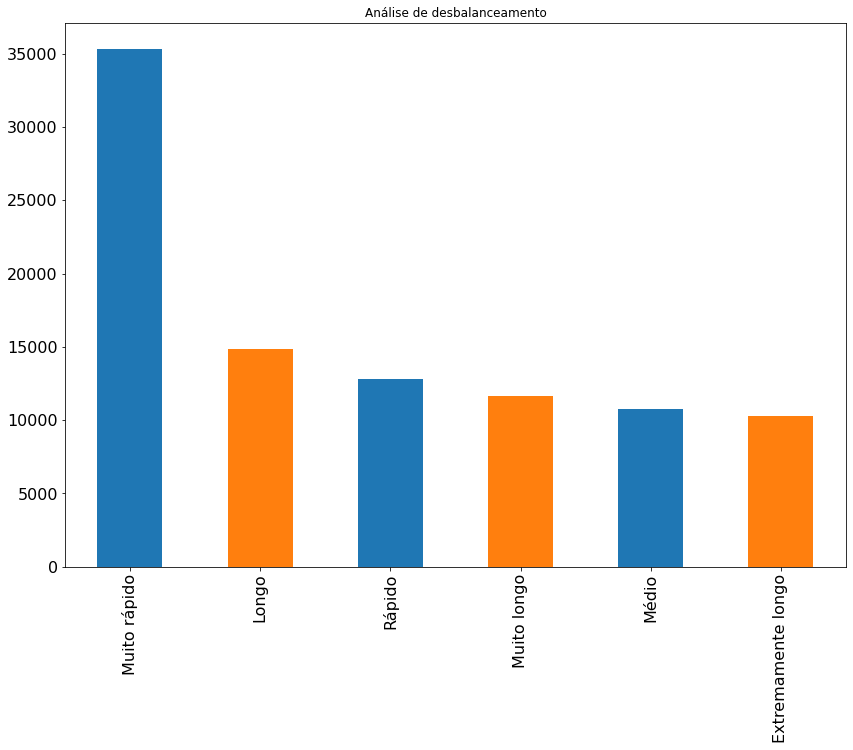

In [4]:
#SIMPLE IMBALANCE ANALYSIS
print(df["tempo_resposta"].value_counts())
target_count = df["tempo_resposta"].value_counts()
target_count.plot(kind='bar', title='Análise de desbalanceamento', figsize=(14,10), fontsize=16, color = ['#1F77B4', '#FF7F0E', '#1F77B4', '#FF7F0E', '#1F77B4', '#FF7F0E'])

In [1]:
def plot_column_distribution(df, column):
    """Plot the distribution of the column from dataframe"""
    
    column_val_df = df[column].value_counts().to_frame().reset_index()
    column_val_df.columns = [column, 'count']
    
    fig = px.bar(data_frame=column_val_df, x=column, y='numero_de_ocorrencias')
    fig.update_layout(
        autosize=True,
        height=600,
        hovermode='closest',
        showlegend=True,
        margin=dict(l=10, r=10, t=30, b=0)
    )
    
    fig.show()
    return None

plot_column_distribution(df, "tempo_resposta")

NameError: name 'df' is not defined

### Modeling

1. A função de ativação das camadas intermediárias que se mostrou mais performática foi a "relu" e para a camada de saída a função "softmax" foi utilizada.

2. A figura de mérito utilizada foi a "accuracy".

3. Apenas 3 "folds" foram escolhidos por questões de performance.

4. O número de neurônios de entrada foi calculado somando-se o número de classes possíveis com o número de colunas de entrada divido por 2 e arredondando para o maior inteiro.

5. O treinamento foi testado para os otimizadores "adam" e "SGD"

6. O número de neurônios de saída é igual ao número de classes possíveis.

7. A quantidade de camadas intermediárias foi obtida empiricamente.

8. O desbalanceamento foi contornado pela utilização de técnicas de "undersampling", pois devido ao grande volume de dados e a relativa proporção entre eles, a retirada de amostras se faz mais adequada do que a geração de amostras artificiais em um grande número.

In [6]:
#COOK PARAMETERS
class_col = 'tempo_resposta'
my_metric = 'accuracy'
random_seed = 33
n_k_folds = 3
my_patience = 30
my_epochs = 10 * my_patience
hidden_activation = 'relu'
activation_function = 'softmax'
hidden_neurons = 100
learning_rate = 0.0001
my_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)
#my_optimizer = tensorflow.keras.optimizers.SGD(learning_rate=learning_rate)
my_loss = 'categorical_crossentropy'
my_batch_size=150

In [7]:
print("GPU disponíveis: ", len(tensorflow.config.list_physical_devices('GPU')))

GPU disponíveis:  1


2022-10-01 10:58:36.934150: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-01 10:58:36.946536: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-01 10:58:37.264778: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-01 10:58:37.264847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 68 deviceMemorySize: 10.00GiB deviceMemoryBandwidth: 707.88GiB/s
2022-10-01 10:58:37.264872: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-10-01 10:58:37.300973: I tensorflow/stream_executor/platfo

In [8]:
def prepareY(df):
    
    # EXTRACT Y AND DROP FROM DATAFRAME
    Y = df[class_col]

    # ENCODE CLASS VALUES AS INTEGERS
    yencoder = LabelEncoder()
    yencoder.fit(Y)
    return yencoder.transform(Y)

y = prepareY(df)
df = df.drop([class_col], axis=1)
pandas.DataFrame(y).head()

,0
0,3
1,2
2,1
3,2
4,2


In [9]:
numerical_ix = df.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = df.select_dtypes(include=['object', 'bool']).columns

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

column_trans = ColumnTransformer(
     [('cat', OrdinalEncoder(),categorical_ix),
      ('num', MinMaxScaler(feature_range=(-1, 1)), numerical_ix)],
     remainder='drop')

column_trans.fit(df)
X = column_trans.transform(df)
pandas.DataFrame(X).head()

,0,1,2,3,4,5,6
0,203.0,3505.0,297.0,1.0,1.0,0.0,0.0
1,148.0,3575.0,49.0,42.0,2.0,0.0,0.0
2,148.0,3575.0,149.0,20.0,2.0,0.0,0.0
3,148.0,3575.0,326.0,42.0,2.0,0.0,0.0
4,148.0,3575.0,383.0,41.0,2.0,0.0,0.0


In [11]:
# SCATTER PLOT
df_plot = pandas.DataFrame(X)
df_plot['Y'] = y

#g = seaborn.pairplot(df_plot, hue='Y', height=3, diag_kind='kde')
#_ = g.map_lower(seaborn.kdeplot, levels=1, color=".2")

In [12]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours()
X_resampled, y_resampled = enn.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=random_seed)

yhot = to_categorical(y_resampled)
yhot_train = to_categorical(y_train)
yhot_test = to_categorical(y_test)

In [13]:
#DEFINE MODEL
def baseline_model():
	# CREATE MODEL
	model = Sequential()
	# DEFINING HIDDEN LAYERS AND NEURONS
	model.add(Dense(16, input_dim=7, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))

	# DEFINING SOFTMAX FOR MULTI-CLASS CLASSIFICATION
	model.add(Dense(6, activation=activation_function))
	# COMPILE MODEL
	model.compile(loss=my_loss, optimizer=my_optimizer, metrics=my_metric)
	return model

# MODEL = BASELINE_MODEL()
cmodel = KerasClassifier(build_fn=baseline_model, epochs=my_epochs, batch_size=my_batch_size, verbose=1)

In [14]:
#SETTING THE NUMBER OF FOLDS
kfold = KFold(n_splits=n_k_folds, shuffle=True)

In [15]:
with tensorflow.device('/gpu:0'):
    result = cross_val_score(cmodel, X_resampled, yhot, cv=kfold, verbose=1)
    print("Baseline: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))

2022-10-01 10:58:39.998050: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
2022-10-01 10:58:39.998551: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-01 10:58:39.999389: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-01 10:58:39.999419: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
core

Epoch 1/600


2022-10-01 10:58:44.079818: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


58/58 [==============================] - 2s 16ms/step - loss: 2.1557 - accuracy: 0.3691
Epoch 2/600
58/58 [==============================] - 1s 15ms/step - loss: 1.2429 - accuracy: 0.4698
Epoch 3/600
58/58 [==============================] - 1s 15ms/step - loss: 1.2268 - accuracy: 0.4655
Epoch 4/600
58/58 [==============================] - 1s 15ms/step - loss: 1.2045 - accuracy: 0.4695
Epoch 5/600
58/58 [==============================] - 1s 15ms/step - loss: 1.2030 - accuracy: 0.4720
Epoch 6/600
58/58 [==============================] - 1s 15ms/step - loss: 1.1962 - accuracy: 0.4780
Epoch 7/600
58/58 [==============================] - 1s 14ms/step - loss: 1.1989 - accuracy: 0.4723
Epoch 8/600
58/58 [==============================] - 1s 15ms/step - loss: 1.1888 - accuracy: 0.4815
Epoch 9/600
58/58 [==============================] - 1s 15ms/step - loss: 1.1851 - accuracy: 0.4889
Epoch 10/600
58/58 [==============================] - 1s 15ms/step - loss: 1.1917 - accuracy: 0.4741
Epoch 11/60

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 26.1min finished


In [16]:
with tensorflow.device('/gpu:0'):
    model = baseline_model()
    model.compile(loss=my_loss, optimizer=my_optimizer, metrics=my_metric)

    history = model.fit(X_train, yhot_train, validation_split=0.3,
                        epochs=my_epochs, batch_size=100, verbose=0)

### Evaluation

1. A avaliação do modelo foi realizada utilizando-se a figura de mérito da acurácia.

2. Foram plotados gráficos de linha comparando os dados do treino e os do teste para a acurácia e para a perda do modelo.

3. Foi plotada uma matriz confusão para a indicação de falsos positivos e falsos negativos e como as classes se confundem entre si no geral.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


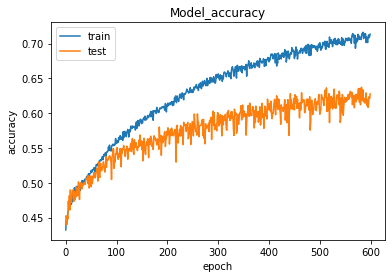

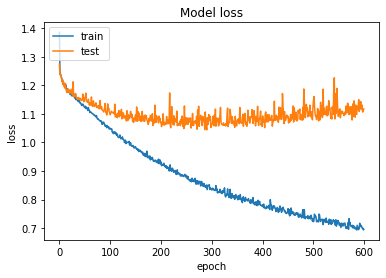

In [17]:
import matplotlib.pyplot as plt
# LIST ALL DATA IN HISTORY
print(history.history.keys())
# SUMMARIZE HISTORY FOR ACCURACY
val_metric_name = 'val_{}'.format(my_metric)
plt.plot(history.history[my_metric])
plt.plot(history.history[val_metric_name])
plt.title('Model_{}'.format(my_metric))
plt.ylabel(my_metric)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# SUMMARIZE HISTORY FOR LOSS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
# EVALUATE THE KERAS MODEL
_, accuracy = model.evaluate(X_test, yhot_test)
print('Accuracy from evaluate: %.2f' % (accuracy*100))

163/163 [==============================] - 2s 10ms/step - loss: 1.0442 - accuracy: 0.6357
Accuracy from evaluate: 63.57


In [19]:
# VERIFYING THE PREDICTION ACCURACY
predict_x = model.predict(X_test)
pred = numpy.argmax(predict_x, axis=1)
print(f'Prediction Accuracy: {(pred == y_test).mean() * 100:f}')

Prediction Accuracy: 63.569776


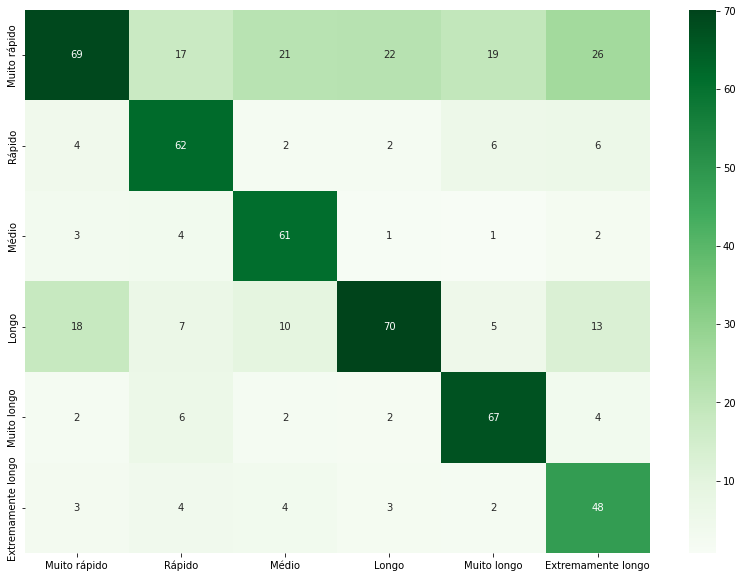

In [20]:
my_classes = ["Muito rápido", "Rápido", "Médio", "Longo", "Muito longo", "Extremamente longo"]
df_Y_categorical = pandas.DataFrame(my_classes)

Y_est = model.predict(X_resampled)
Y_est_pred = numpy.argmax(Y_est, axis=1)

my_conf = confusion_matrix(y_resampled, Y_est_pred, labels=[0,1,2,3,4,5])
df_conf = pandas.DataFrame(100.0*my_conf/my_conf.sum(axis=0), index=['{}'.format(x) for x in my_classes], columns=my_classes)

fig, ax = pyplot.subplots(figsize=(14,10)) 
_ = seaborn.heatmap(df_conf, cmap="Greens", ax=ax, annot=True, fmt='.0f')

In [21]:
# COMPARISON WITH OTHER CLASSIFIERS
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

with tensorflow.device('/gpu:0'):
    dnns_classifier = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes = [100]*12))
    dnns_classifier.fit(numpy.array(X_train), y_train)
    dnns_predictions_labels = dnns_classifier.predict(X_test)
    
metrics.accuracy_score(y_test, dnns_predictions_labels)

/home/higoreller/miniconda3/envs/condaenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



0.6204703161141095

In [22]:

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OutputCodeClassifier

model = LogisticRegression(random_state=42)
ecoc = OutputCodeClassifier(model, code_size=5, random_state=42).fit(X_train, y_train)

y_pred = ecoc.predict(X_test)

metrics.accuracy_score(y_test, y_pred)

/home/higoreller/miniconda3/envs/condaenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/higoreller/miniconda3/envs/condaenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

0.471858134155744